In [3]:
import pandas as pd
from rake_nltk import Rake
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
sentiment_df = pd.read_csv('userSentiment.csv')
sentiment_df

,user_id,user_name,status
0,50393960,BillGates,neutral


In [13]:
films_df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

films_df = films_df[['Title','Genre']]
films_df.head()

,Title,Genre
0,The Shawshank Redemption,"Crime, Drama"
1,The Godfather,"Crime, Drama"
2,The Godfather: Part II,"Crime, Drama"
3,The Dark Knight,"Action, Crime, Drama"
4,12 Angry Men,"Crime, Drama"


In [14]:
# initializing the new column
films_df['bag_of_words'] = ""

for index, row in films_df.iterrows():
    genre = row['Genre']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(genre)

    for word in r.get_ranked_phrases():
        row['bag_of_words'] += word + " "
        
row['bag_of_words'] = row['bag_of_words'][:-1]

# dropping the Genre column
films_df.drop(columns = ['Genre'], inplace = True)

films_df.head()

,Title,bag_of_words
0,The Shawshank Redemption,drama crime
1,The Godfather,drama crime
2,The Godfather: Part II,drama crime
3,The Dark Knight,drama crime action
4,12 Angry Men,drama crime


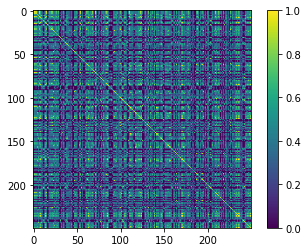

In [15]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(films_df['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

plt.imshow(cosine_sim)
plt.colorbar()
plt.show()

In [28]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(films_df.index)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(genre, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the genre
    idx = indices[indices == genre].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(films_df.index)[i])
        
    return recommended_movies

In [29]:
lista = recommendations('Fargo')
print(lista)

IndexError: index 0 is out of bounds for axis 0 with size 0